In [1]:
! pip install scanpy
! pip install anndata
! pip install scrublet
! pip install scipy


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=5c3a8c49113076db355c85813d50cca1591ed696ad9f90bc73e5a0a34ed948cf
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_

In [7]:
import os
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import scrublet as scr
import scipy.sparse
import pandas as pd

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
! ls

Mounted at /content/drive
drive  sample_data


In [4]:
# Set the working directory
working_dir = "/content/drive/MyDrive/jj/projects/2024/Armstrong_MS/SC_mouse/matrices/"
os.chdir(working_dir)

# Verify the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/jj/projects/2024/Armstrong_MS/SC_mouse/matrices


In [12]:
metadata = pd.read_csv("metadata.txt", sep="\t")
# Rename the first column
metadata.rename(columns={"scseq ID": "sample_name"}, inplace=True)
metadata.head()

,sample_name,Disease,Diet,Tissues,Mouse ID
0,C1,MS,B-fructan,Gut,7_BF-21-Cecum
1,C2,MS,B-fructan,Gut,8_BF-26-Cecum
2,C3,MS,B-fructan,Gut,9_BF-27-Cecum
3,C4,MS,Control,Gut,10_CON-23-Cecum
4,C5,MS,Control,Gut,11_CON-25-Cecum


In [17]:
# Initialize dictionaries to store AnnData objects
adata_dict_spine = {}
adata_dict_cecum = {}

# Iterate over each sample directory
for sample_dir in sample_dirs:
    # Extract sample name
    sample_name = os.path.basename(sample_dir).replace("_filtered_feature_bc_matrix", "")
    print(f"Loading data for {sample_name}...")

    # Read 10X data
    adata = sc.read_10x_mtx(sample_dir, var_names="gene_symbols", cache=True)

    # Add sample prefix to cell names to ensure uniqueness
    adata.obs_names = [f"{sample_name}_{cell}" for cell in adata.obs_names]
    adata.obs["sample"] = sample_name  # Add sample name to metadata

    # Determine tissue type based on sample naming convention
    if sample_name.startswith("B"):
        # Spine sample
        diet = metadata.loc[metadata["sample_name"] == sample_name, "Diet"].values[0]
        if diet == "B-fructan":
            adata.obs["diet"] = "B-fructan"
            adata_dict_spine[f"{sample_name}_fructan"] = adata
        elif diet == "Control":
            adata.obs["diet"] = "Control"
            adata_dict_spine[f"{sample_name}_control"] = adata
    elif sample_name.startswith("C"):
        # Gut sample
        diet = metadata.loc[metadata["sample_name"] == sample_name, "Diet"].values[0]
        if diet == "B-fructan":
            adata.obs["diet"] = "B-fructan"
            adata_dict_cecum[f"{sample_name}_fructan"] = adata
        elif diet == "Control":
            adata.obs["diet"] = "Control"
            adata_dict_cecum[f"{sample_name}_control"] = adata

# Print the number of samples in each group
print(f"Number of spine samples: {len(adata_dict_spine)}")
print(f"Number of gut samples: {len(adata_dict_cecum)}")

Loading data for C2...
Loading data for B8...
Loading data for B7...
Loading data for B9...
Loading data for B10...
Loading data for B12...
Loading data for C4...
Loading data for C5...
Loading data for C3...
Loading data for B11...
Loading data for C1...
Loading data for C6...
Number of spine samples: 6
Number of gut samples: 6


In [34]:
# Merge all cecum samples into a single AnnData object
cecum_adata_combined = sc.concat(
    adata_dict_cecum,
    axis=0,
    label="original_sample",  # Column name to store sample labels
    merge="same"
)

# Merge all spine samples into a single AnnData object
spine_adata_combined = sc.concat(
    adata_dict_spine,
    axis=0,
    label="original_sample",  # Column name to store sample labels
    merge="same"
)

# Verify uniqueness in combined dataset
cecum_n_duplicates = sum(cecum_adata_combined.obs_names.duplicated())
spine_n_duplicates = sum(spine_adata_combined.obs_names.duplicated())

if cecum_n_duplicates > 0:
    print(f"Warning: {cecum_n_duplicates} duplicate observations found in combined dataset")
    cecum_adata_combined.obs_names_make_unique()

if spine_n_duplicates > 0:
    print(f"Warning: {spine_n_duplicates} duplicate observations found in combined dataset")
    spine_adata_combined.obs_names_make_unique()


# Determine some QC parameters
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
cecum_adata_combined.var["mt"] = cecum_adata_combined.var_names.str.startswith("mt-")
spine_adata_combined.var["mt"] = spine_adata_combined.var_names.str.startswith("mt-")

# ribosomal genes
cecum_adata_combined.var["ribo"] = cecum_adata_combined.var_names.str.startswith(("Rps", "Rpl"))
spine_adata_combined.var["ribo"] = spine_adata_combined.var_names.str.startswith(("Rps", "Rpl"))


sc.pp.calculate_qc_metrics(
cecum_adata_combined, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

sc.pp.calculate_qc_metrics(
spine_adata_combined, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)


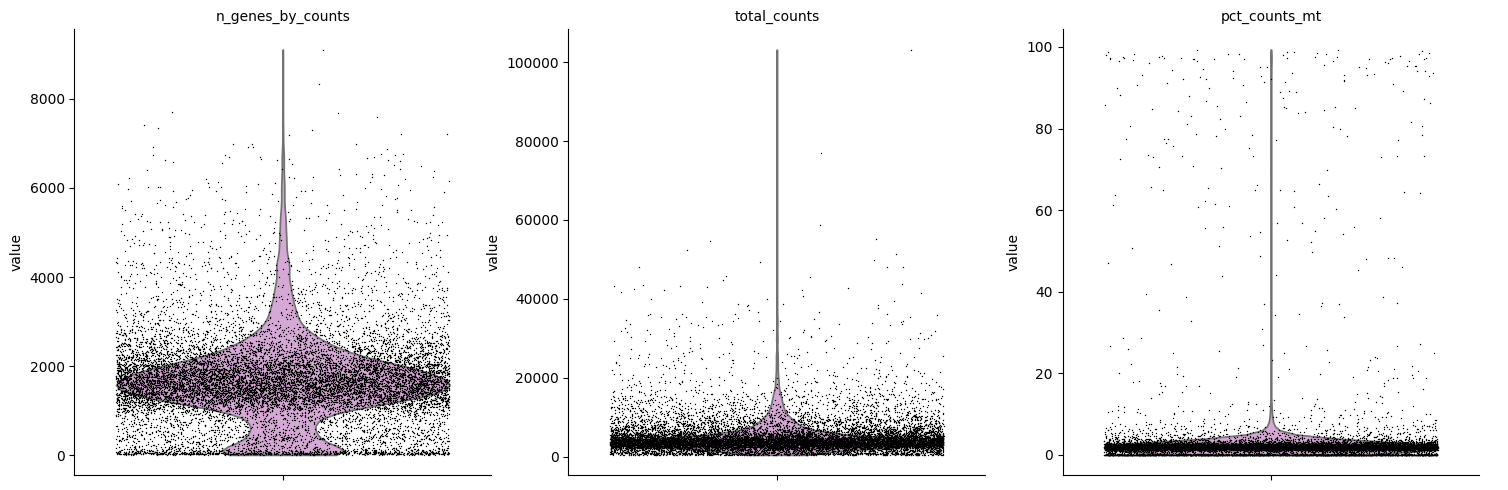

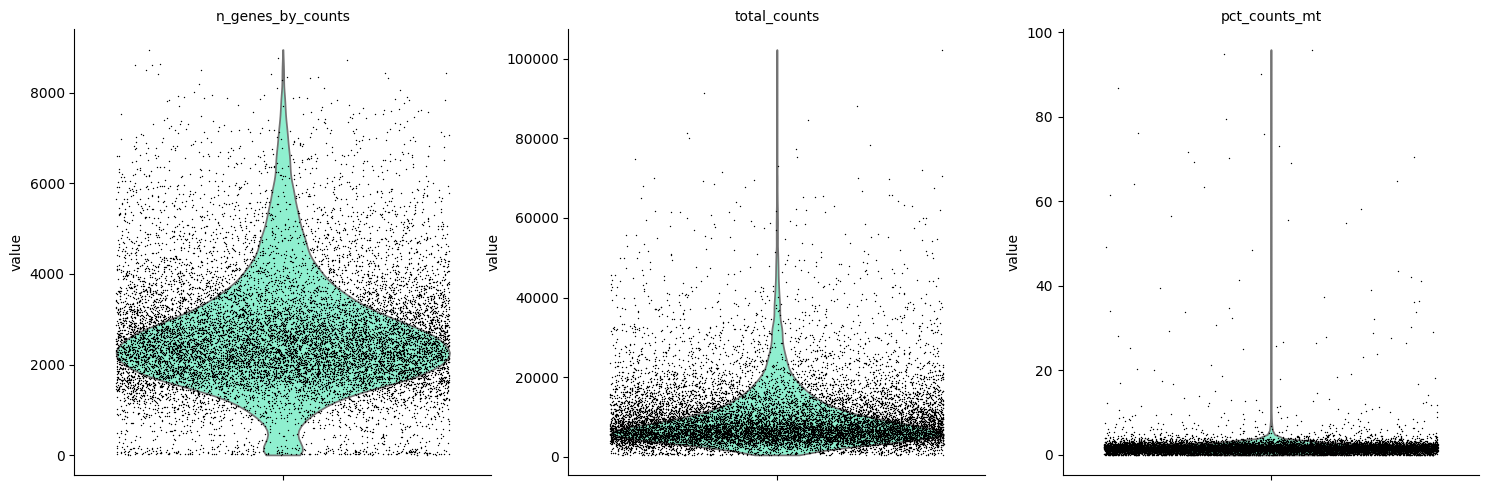

In [35]:
output_file = "_cecum_merged_plot.png"
sc.pl.violin(
    cecum_adata_combined,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    color="plum",
    size=1,
    multi_panel=True,
    save=output_file

)

output_file = "_spine_merged_plot.png"
sc.pl.violin(
    spine_adata_combined,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    color="aquamarine",
    size=1,
    multi_panel=True,
    save=output_file

)

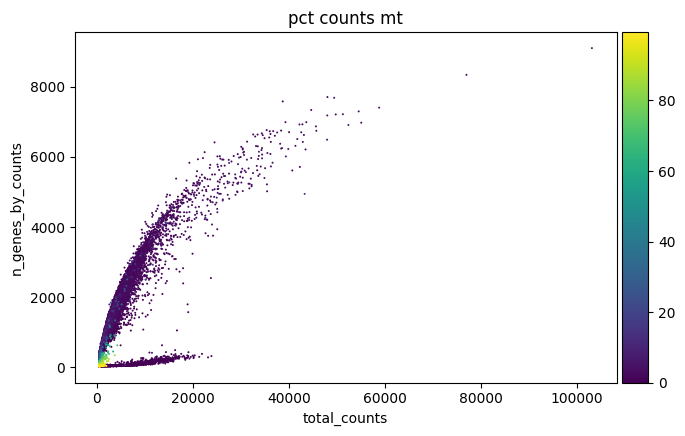

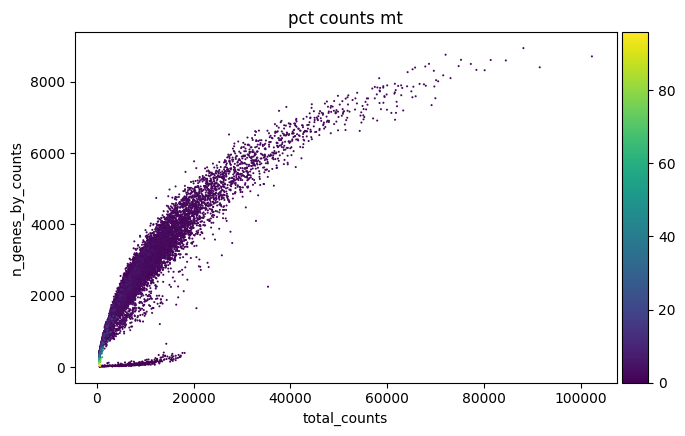

In [36]:
output_file = "_cecum_merged_plot.png"
sc.pl.scatter(
    cecum_adata_combined,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt",
    save=output_file)

output_file = "_spine_merged_plot.png"
sc.pl.scatter(
    spine_adata_combined,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt",
    save=output_file)


In [38]:
# Filter conservatively
# cecum
sc.pp.filter_cells(cecum_adata_combined, min_genes=200)
sc.pp.filter_genes(cecum_adata_combined, min_cells=3)

# spine
sc.pp.filter_cells(spine_adata_combined, min_genes=200)
sc.pp.filter_genes(spine_adata_combined, min_cells=3)


In [39]:
# Detect doublets
# Doublet detection using Scrublet
cecum_adata_combined.layers["counts"] = cecum_adata_combined.X.copy()  # Save count data before normalization
spine_adata_combined.layers["counts"] = spine_adata_combined.X.copy()  # Save count data before normalization

# If the data is in sparse format, convert it to a dense matrix
cecum_counts_matrix = cecum_adata_combined.X.toarray() if scipy.sparse.issparse(cecum_adata_combined.X) else cecum_adata_combined.X
spine_counts_matrix = spine_adata_combined.X.toarray() if scipy.sparse.issparse(spine_adata_combined.X) else spine_adata_combined.X

# Initialize Scrublet
cecum_scrub = scr.Scrublet(cecum_counts_matrix)
spine_scrub = scr.Scrublet(spine_counts_matrix)

# Run Scrublet
cecum_doublet_scores, cecum_predicted_doublets = cecum_scrub.scrub_doublets()
spine_doublet_scores, spine_predicted_doublets = spine_scrub.scrub_doublets()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 18.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.8%
Elapsed time: 36.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.21
Detected doublet rate = 8.5%
Estimated detectable doublet fraction = 56.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.0%
Elapsed time: 48.6 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

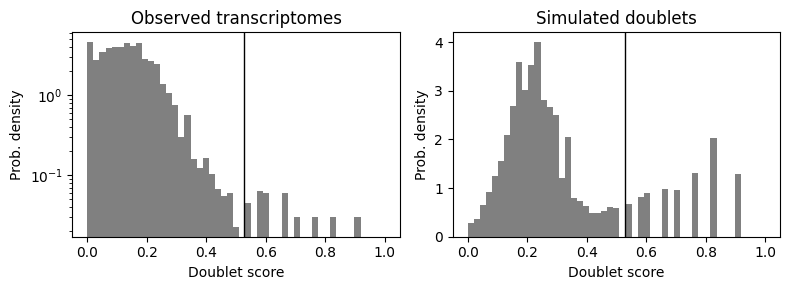

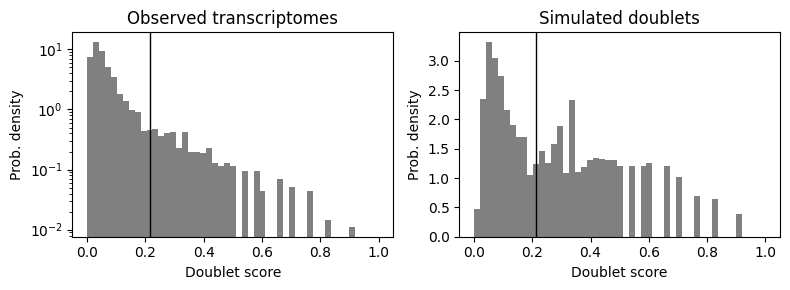

In [40]:
# Plot doublets results
# Add the results back to the AnnData object
# cecum
cecum_adata_combined.obs["doublet_scores"] = cecum_doublet_scores
cecum_adata_combined.obs["predicted_doublets"] = cecum_predicted_doublets.astype(str)  # Ensure boolean values are converted to strings for visualization

cecum_adata_combined = cecum_adata_combined[cecum_adata_combined.obs["predicted_doublets"] == "False", :]

# Save a histogram of doublet scores
cecum_scrub.plot_histogram()

# Spine
spine_adata_combined.obs["doublet_scores"] = spine_doublet_scores
spine_adata_combined.obs["predicted_doublets"] = spine_predicted_doublets.astype(str)  # Ensure boolean values are converted to strings for visualization

spine_adata_combined = spine_adata_combined[spine_adata_combined.obs["predicted_doublets"] == "False", :]

# Save a histogram of doublet scores
spine_scrub.plot_histogram()

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


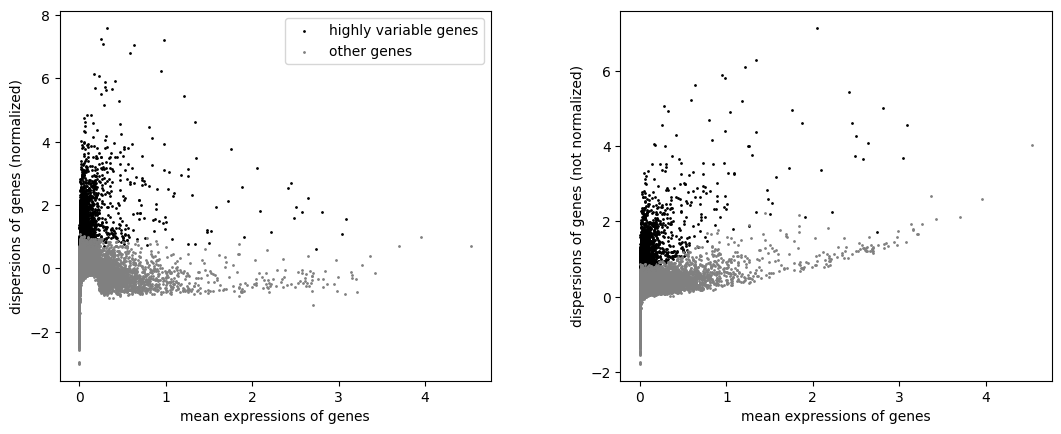

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


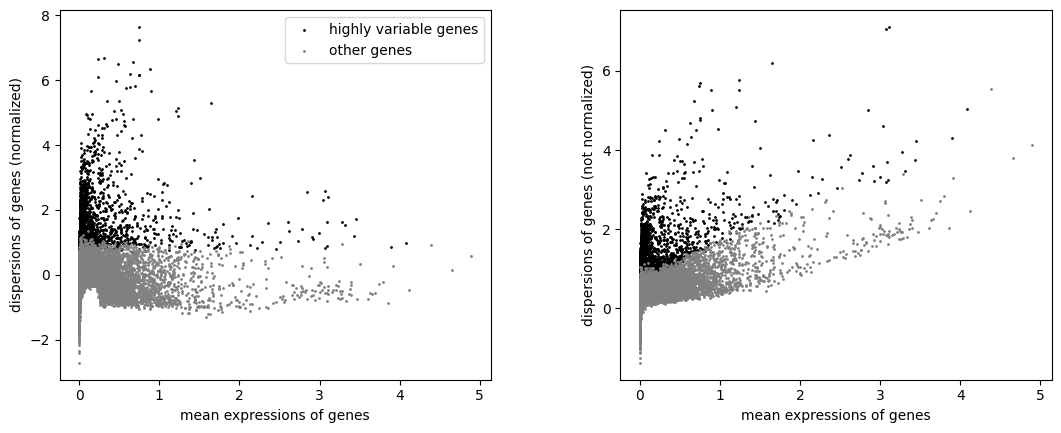

In [41]:
# Cecum
# Normalizing to median total counts
sc.pp.normalize_total(cecum_adata_combined)
# Logarithmize the data
sc.pp.log1p(cecum_adata_combined)

# Feature selection
sc.pp.highly_variable_genes(cecum_adata_combined, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(cecum_adata_combined)

# Spine
# Normalizing to median total counts
sc.pp.normalize_total(spine_adata_combined)
# Logarithmize the data
sc.pp.log1p(spine_adata_combined)

# Feature selection
sc.pp.highly_variable_genes(spine_adata_combined, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(spine_adata_combined)


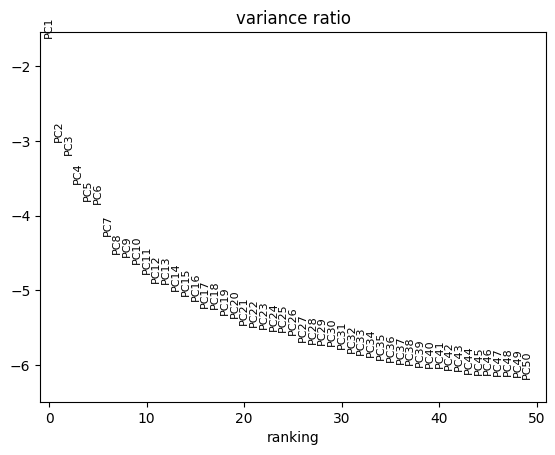

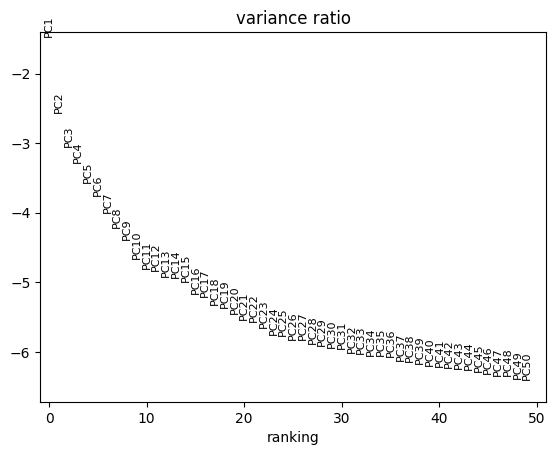

In [42]:
# Run PCA
# Cecum
sc.tl.pca(cecum_adata_combined)
# Elbow plot
output_file = "_cecum_merged_elbow_plot.png"
sc.pl.pca_variance_ratio(
    cecum_adata_combined,
    n_pcs=50,
    log=True,
    save=output_file)

# Spine
sc.tl.pca(spine_adata_combined)
# Elbow plot
output_file = "_spine_merged_elbow_plot.png"
sc.pl.pca_variance_ratio(
    spine_adata_combined,
    n_pcs=50,
    log=True,
    save=output_file)


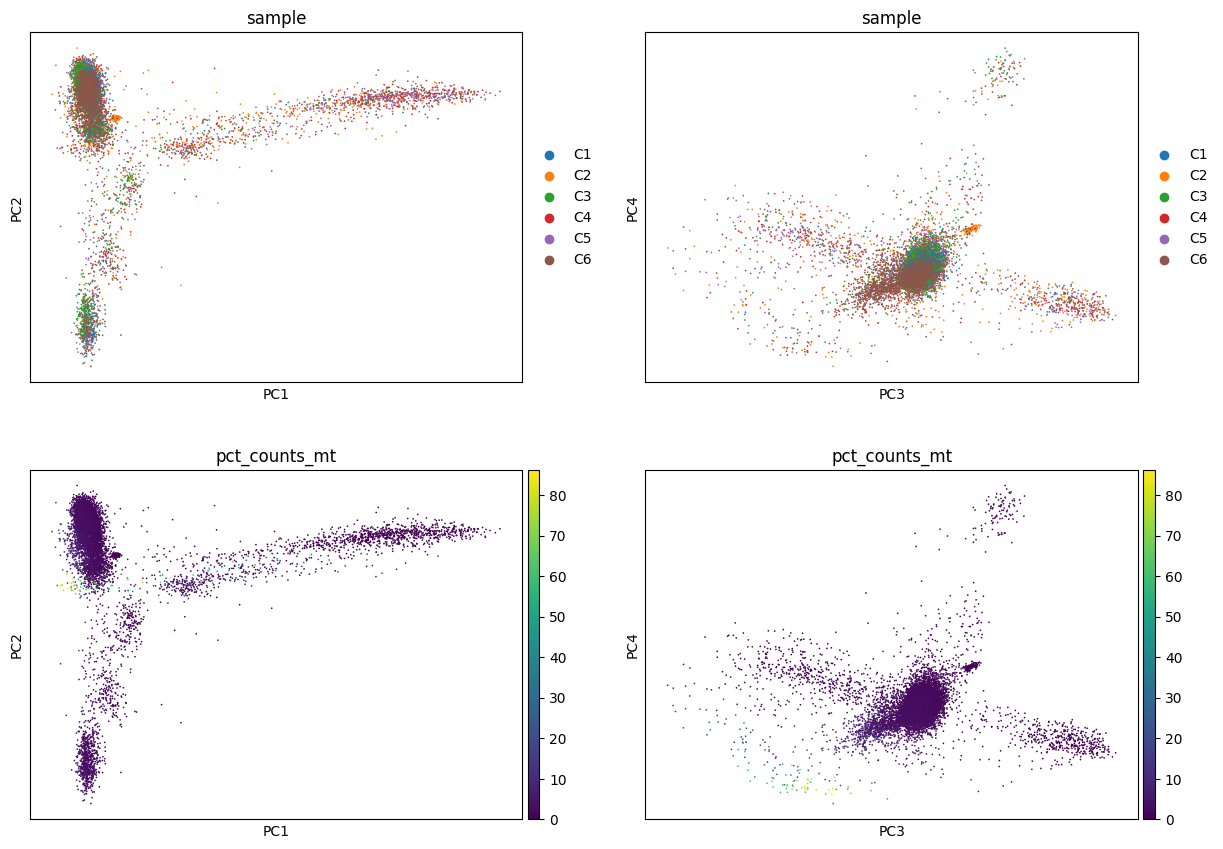

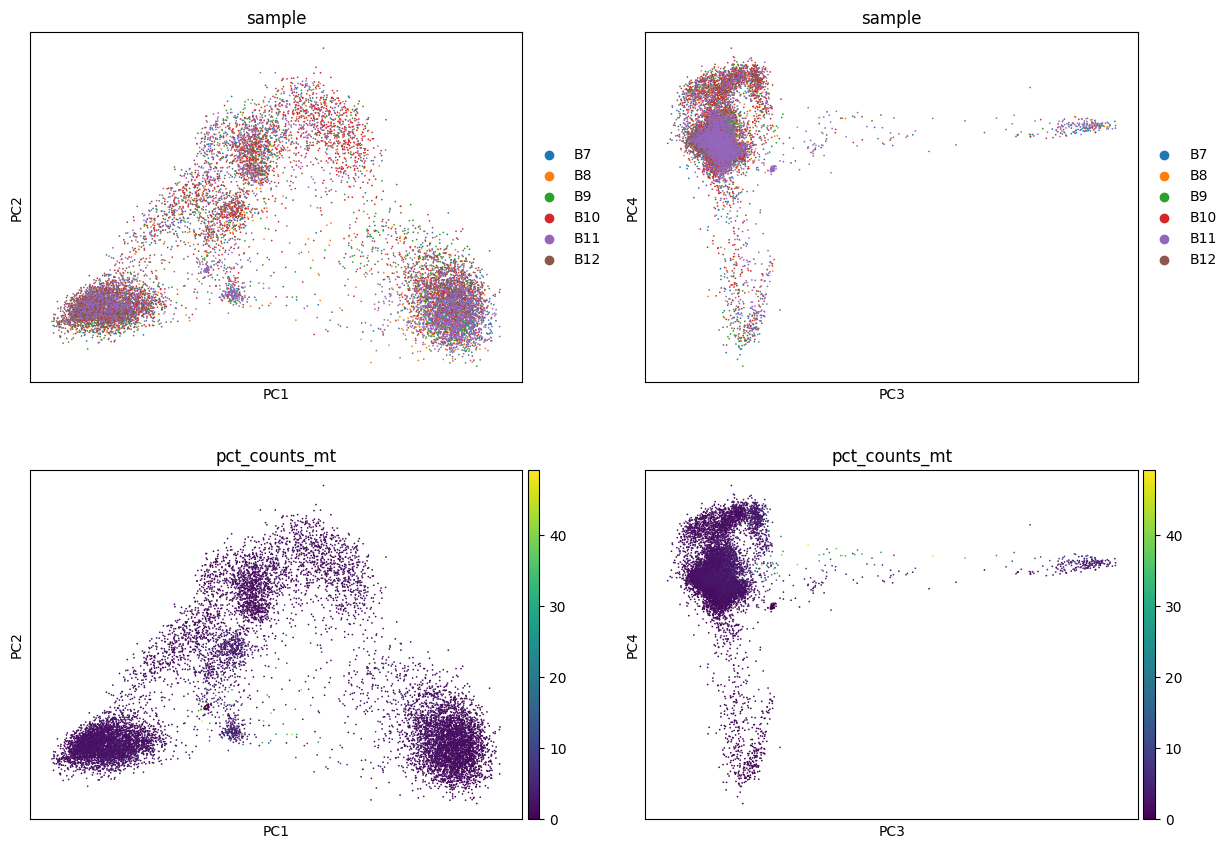

In [43]:
# Cecum
# Plot PCAs
output_file = "_cecum_merged_PCAs_plot.png"
sc.pl.pca(
    cecum_adata_combined,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=6,
    save=output_file
)

# Spine
# Plot PCAs
output_file = "_spine_merged_PCAs_plot.png"
sc.pl.pca(
    spine_adata_combined,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=6,
    save=output_file
)


In [33]:
# prompt: quality filtering of cecum_adata_combined and spine_adata_combined

# Filter cells based on QC metrics
cecum_adata_combined = cecum_adata_combined[
    (cecum_adata_combined.obs["pct_counts_mt"] < 10) &
    (cecum_adata_combined.obs["n_genes_by_counts"] < 6000) &
    (cecum_adata_combined.obs["n_genes_by_counts"] > 200)
]

spine_adata_combined = spine_adata_combined[
    (spine_adata_combined.obs["pct_counts_mt"] < 10) &
    (spine_adata_combined.obs["n_genes_by_counts"] < 6000) &
    (spine_adata_combined.obs["n_genes_by_counts"] > 200)
]

KeyError: 'original_sample'

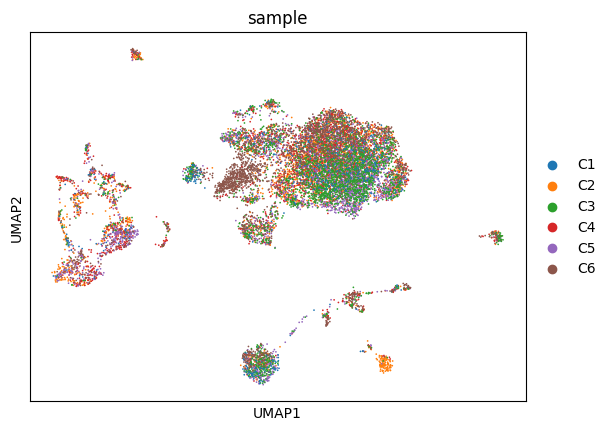

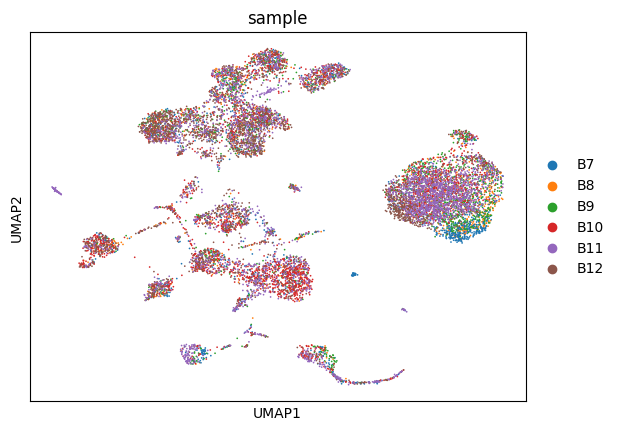

In [44]:
# Cecum
# Neirest neighbor graph construction and visualization
# Construct neighbors graph using PCA representation of data
sc.pp.neighbors(cecum_adata_combined)

# Embed the graph into UMAP
sc.tl.umap(cecum_adata_combined)

# Visualize UMAP according to sample
output_file = "_cecum_merged_UMAP_plot.png"
sc.pl.umap(
    cecum_adata_combined,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=6,
    save=output_file
)

# Spine
# Neirest neighbor graph construction and visualization
# Construct neighbors graph using PCA representation of data
sc.pp.neighbors(spine_adata_combined)

# Embed the graph into UMAP
sc.tl.umap(spine_adata_combined)

# Visualize UMAP according to sample
output_file = "_spine_merged_UMAP_plot.png"
sc.pl.umap(
    spine_adata_combined,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=6,
    save=output_file
)

In [45]:
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.4 MB/s eta 0:00:00


<ipython-input-46-1dade52156a7>:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(cecum_adata_combined, n_iterations=2)


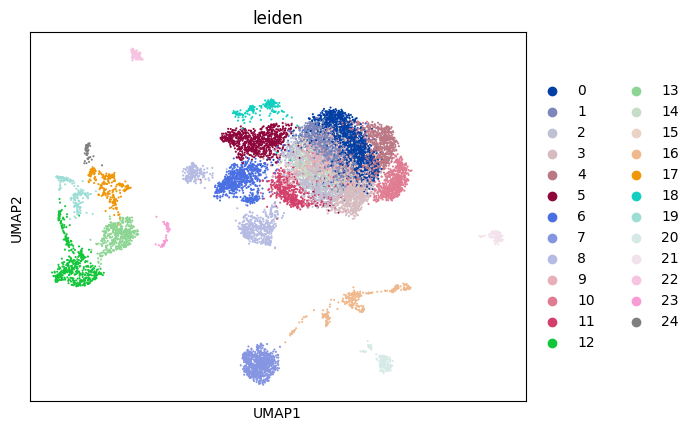

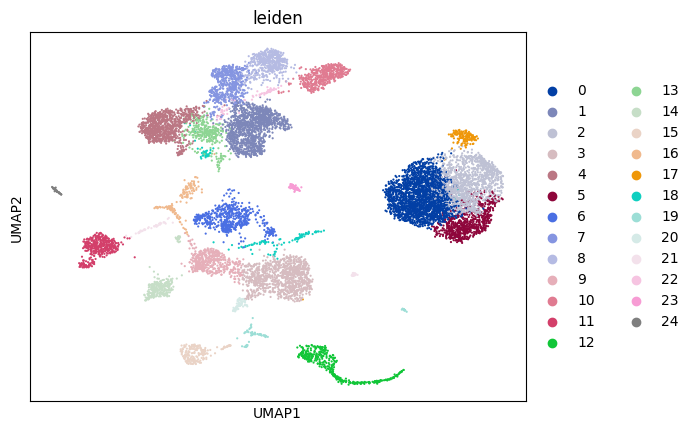

In [46]:
# Clustering
# As with Seurat and many other frameworks, we recommend the Leiden graph-clustering
# method (community detection based on optimizing modularity) [Traag et al., 2019].
# Note that Leiden clustering directly clusters the neighborhood graph of cells, which
# we already computed in the previous section.

# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
# Cecum
sc.tl.leiden(cecum_adata_combined, n_iterations=2)
output_file = "_cecum_merged_UMAP_afterClustering_plot.png"
sc.pl.umap(
    cecum_adata_combined,
    color=["leiden"],
    save=output_file,
)

# Spine
sc.tl.leiden(spine_adata_combined, n_iterations=2)
output_file = "_spine_merged_UMAP_afterClustering_plot.png"
sc.pl.umap(
    spine_adata_combined,
    color=["leiden"],
    save=output_file,
)

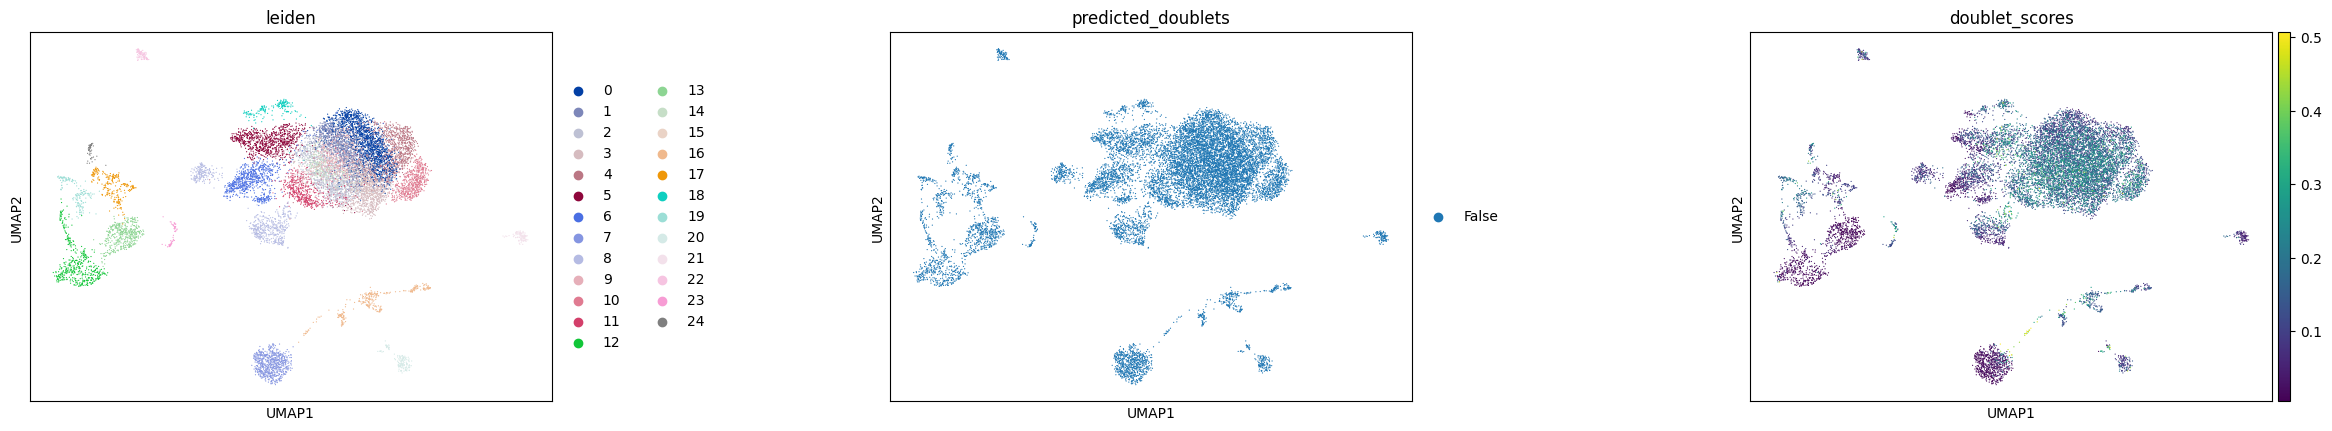

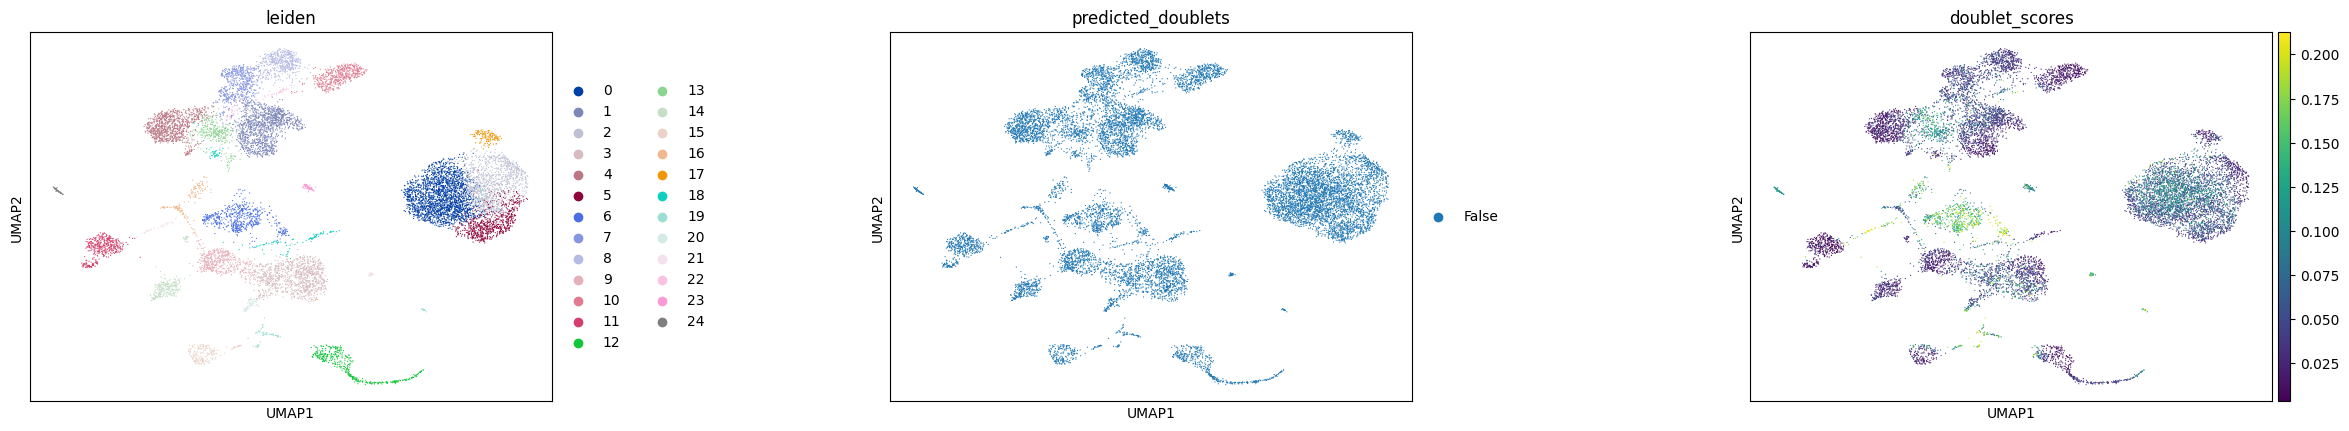

In [47]:
# Re-assess quality control and cell filtering
# As indicated before, we will now re-assess our filtering strategy
# by visualizing different QC metrics using UMAP.

# Cecum
output_file = "_cecum_merged_UMAP_doublets_plot.png"
sc.pl.umap(
    cecum_adata_combined,
    color=["leiden", "predicted_doublets", "doublet_scores"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
    save=output_file
)

# Spine
output_file = "_spine_merged_UMAP_doublets_plot.png"
sc.pl.umap(
    spine_adata_combined,
    color=["leiden", "predicted_doublets", "doublet_scores"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
    save=output_file
)

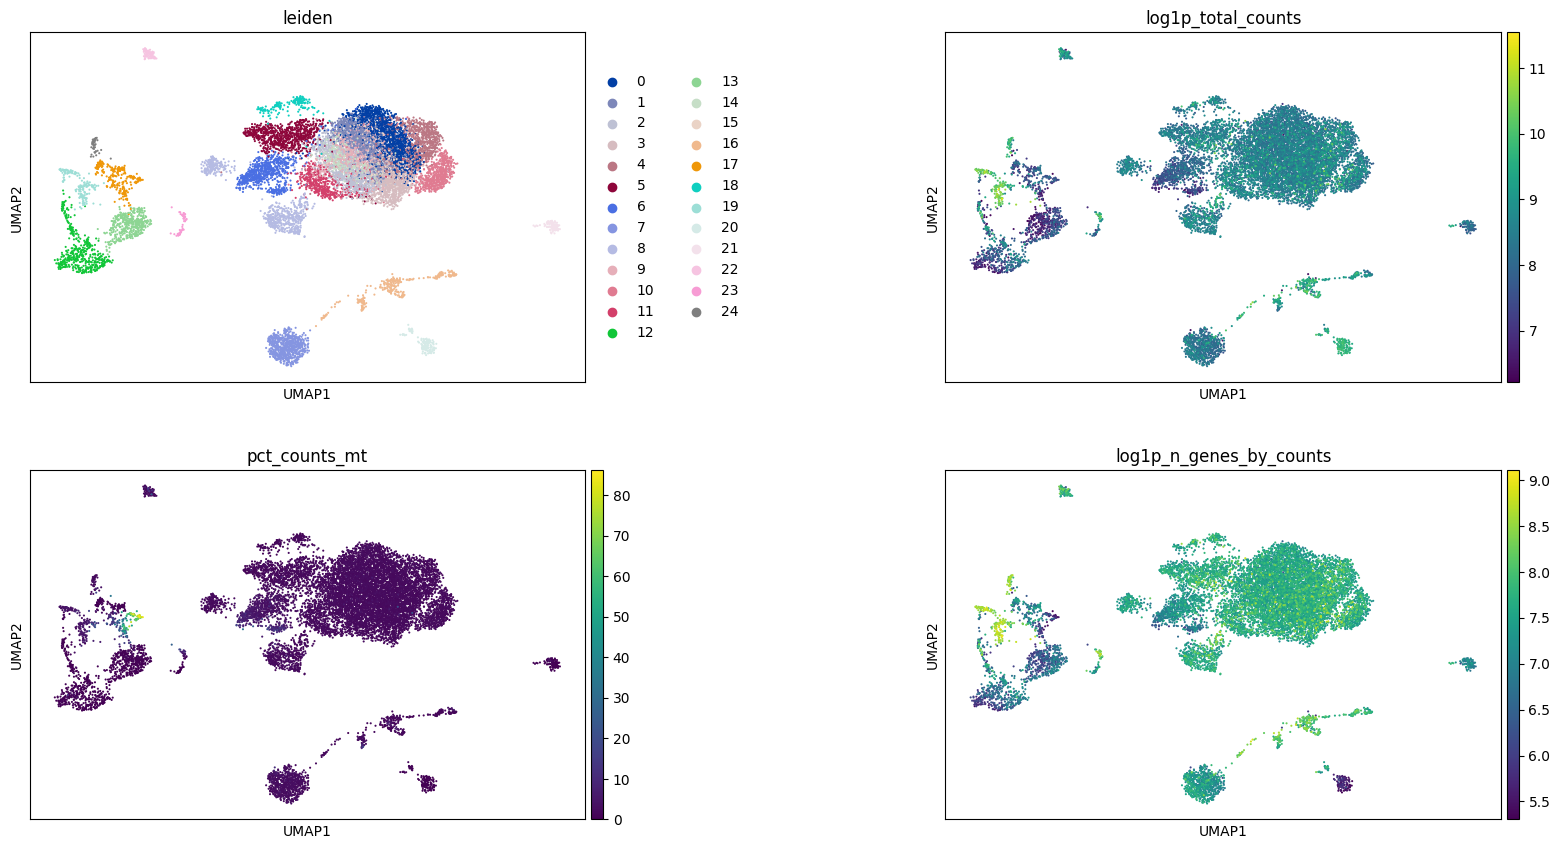

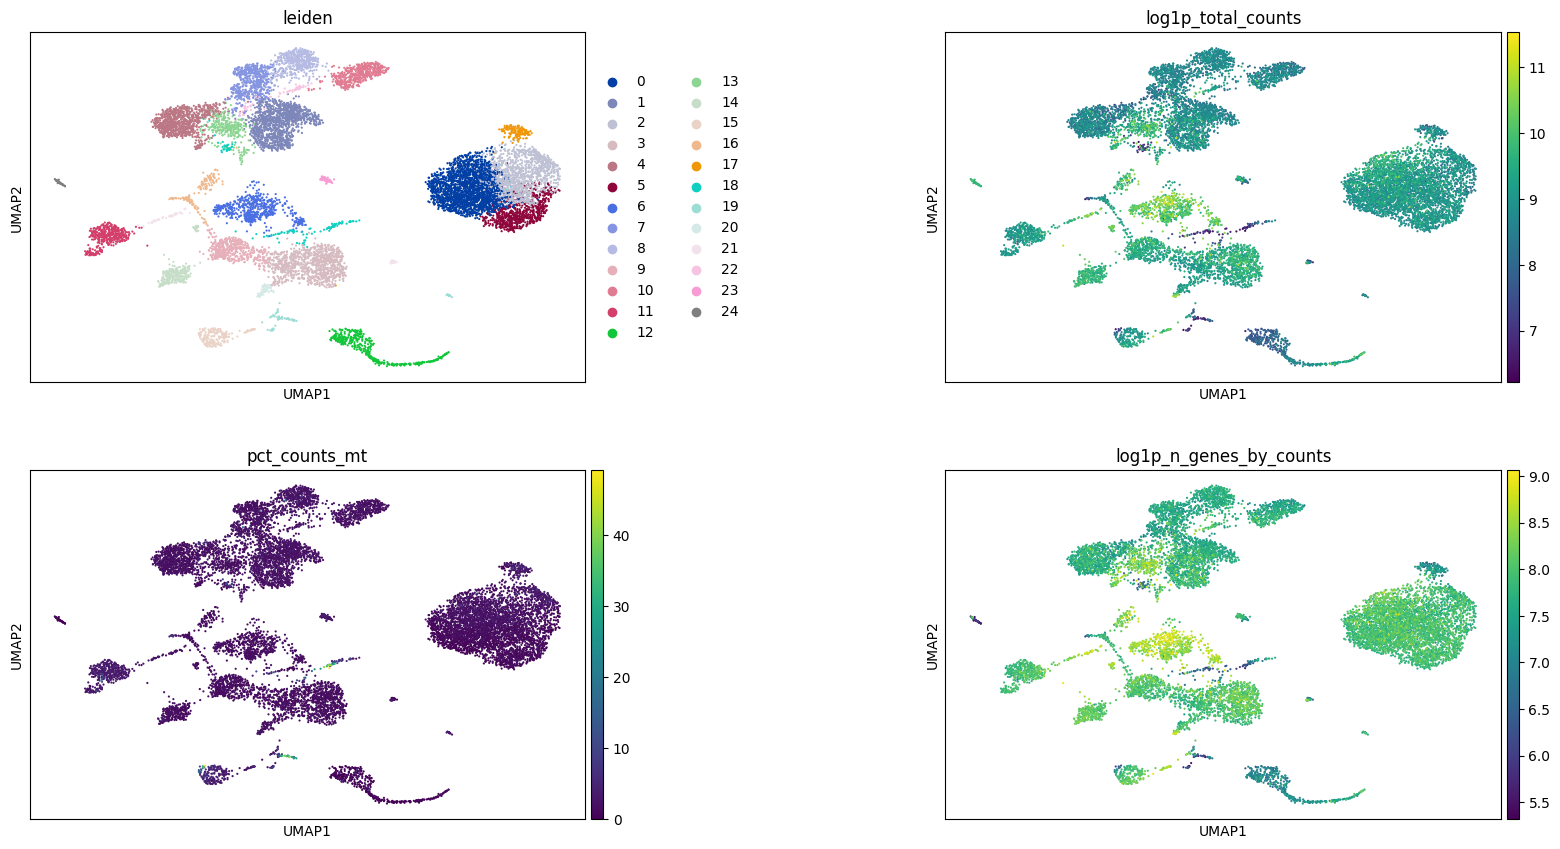

In [48]:
# QC plots
# Cecum
output_file = "_cecum_merged_UMAP_QC_plots.png"
sc.pl.umap(
    cecum_adata_combined,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
    save=output_file
)

# Spine
output_file = "_spine_merged_UMAP_QC_plots.png"
sc.pl.umap(
    spine_adata_combined,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
    save=output_file
)